<a href="https://colab.research.google.com/github/saimani5/VAE-tutorials/blob/main/Intro_to_AE_and_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing necessary packages
!pip install pycroscopy  #For AE
!pip install atomai  # We will use this for resizing and VAE
!pip install kornia pyroved

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 KB 916.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 75.7 MB/s eta 0:00:00
  Created wheel for pysptools: filename=pysptools-0.15.0-py3-none-any.whl size=8133744 sha256=f126e17147e1dba253fc9472457fd69ef92b936bab200e782440547e84385e0d
  Stored in directory: /root/.cache/pip/wheels/c1/18/a2/c6528d

In [ ]:
# Importing necessary packages
import torch
import numpy as np
import matplotlib.pyplot as plt
tt = torch.tensor

import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import atomai as aoi
import kornia as K
import pyroved as pv

tt = torch.tensor
from PIL import Image

# Pycroscopy has the regular autoencoders
from pycroscopy.learn.dl import AutoEncoder as AE
from pycroscopy.learn.dl import DenoisingAutoEncoder as DAE
from pycroscopy.learn.dl import Trainer

# Regular Autoencoders

In [ ]:
# Download the MNIST dataset here
from torchvision import datasets
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Preparing the MNIST dataset for training purposes

imstack_train = mnist_trainset.data.numpy()
labels_train = mnist_trainset.targets.numpy()

#Pick only every 5th item of the array since we have limited GPU space
imstack_train = imstack_train[::5]
labels_train = labels_train[::5]


#Resizing the image stack
imstack_train = aoi.utils.cv_resize_stack(imstack_train, (32,32))
# Adding the pseudo channel dimension at the second axis
imstack_train = imstack_train[:, np.newaxis, :, :]
print(imstack_train.shape, labels_train.shape)

(12000, 1, 32, 32) (12000,)


In [ ]:
# Here we demonstrate some of the use case scenarios of autoencoders
# a) Noise cleaning
# b) Filling missing pixels

imstack_norm = imstack_train/255

# For noisy images we have used gaussian noise
noise_factor = 0.5
imstack_noisy = imstack_norm + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imstack_norm.shape)
imstack_noisy = np.clip(imstack_noisy, 0., 1.)


# For missing pixels, we randomly select 50% of the pixel location and set their values to zero
imstack_mispx = np.copy(imstack_norm)
inds = np.random.choice([True, False], size = imstack_norm.shape)
imstack_mispx[inds] = 0.0

Normalized images
Noisy images
Missing Pixel images


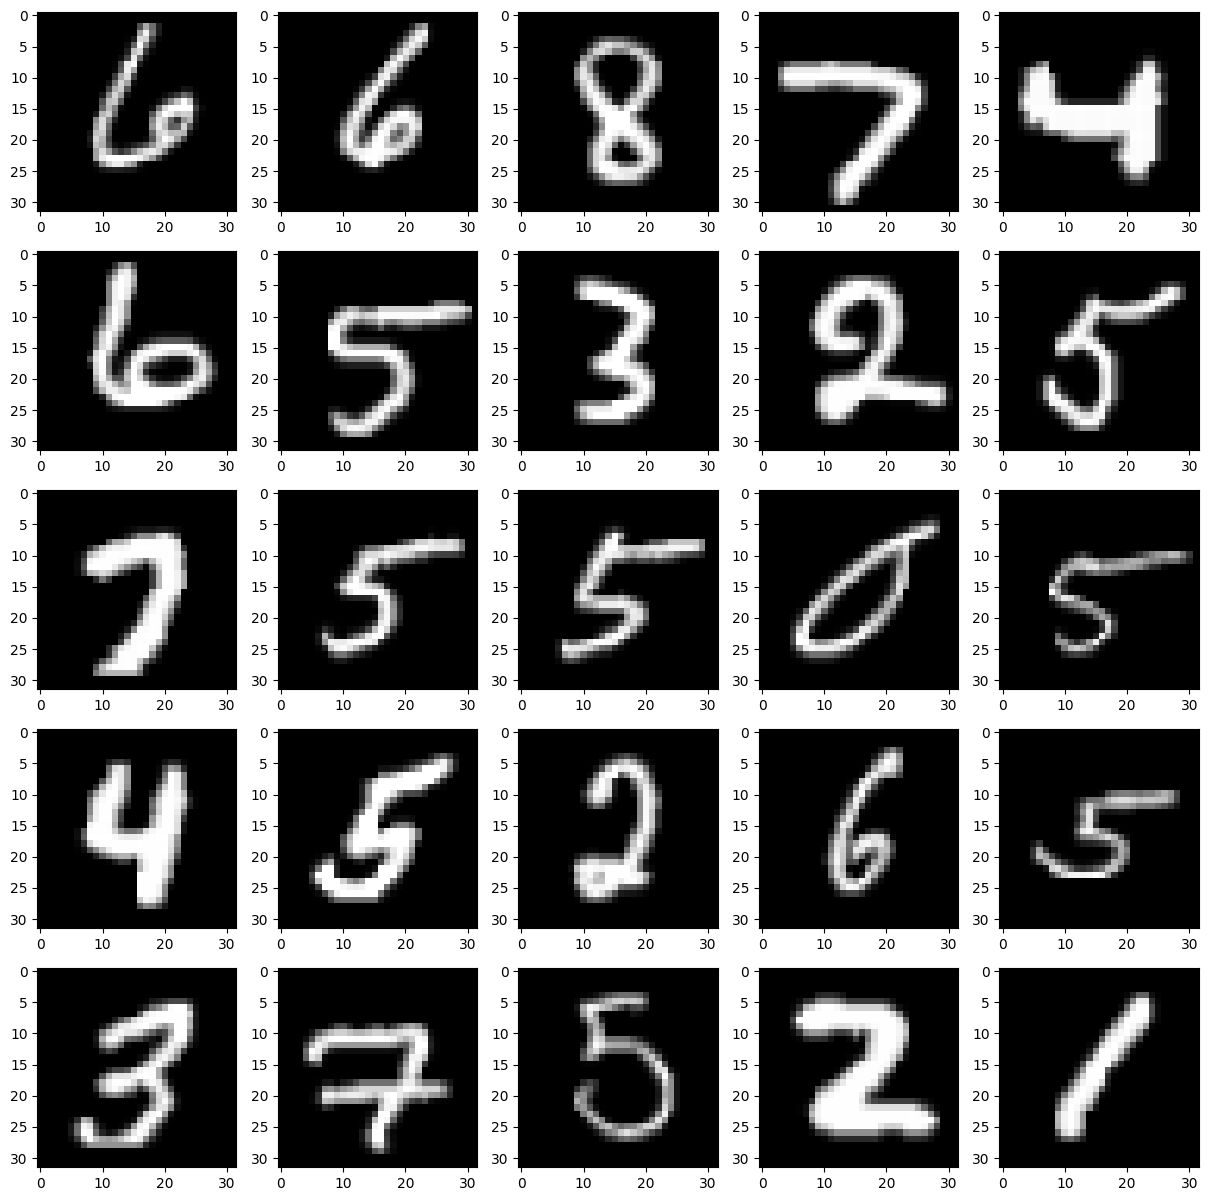

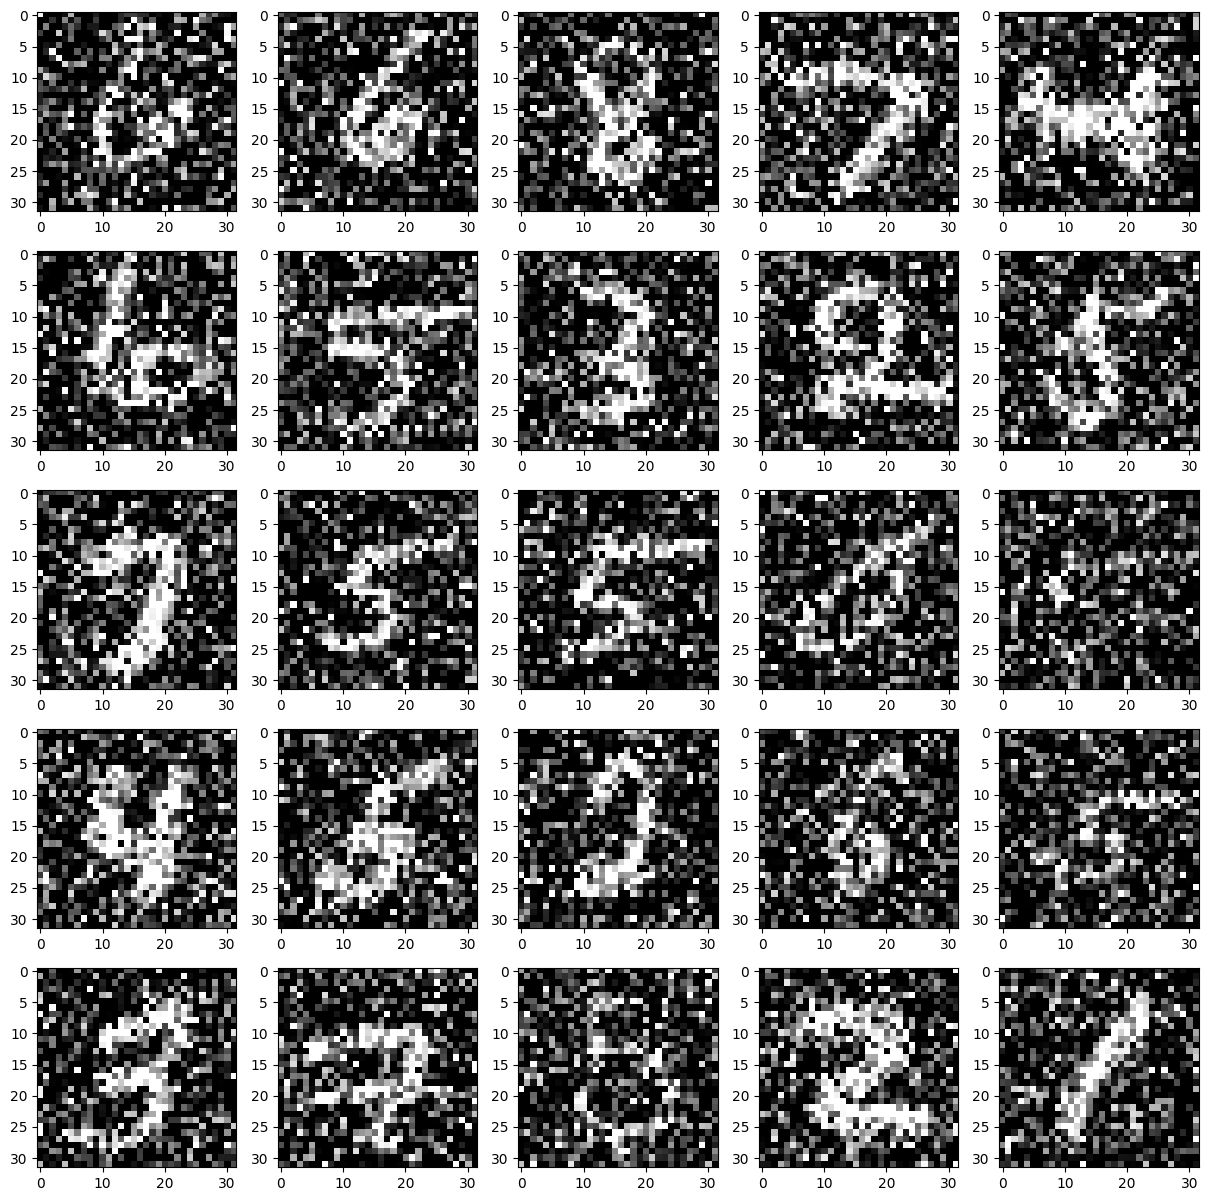

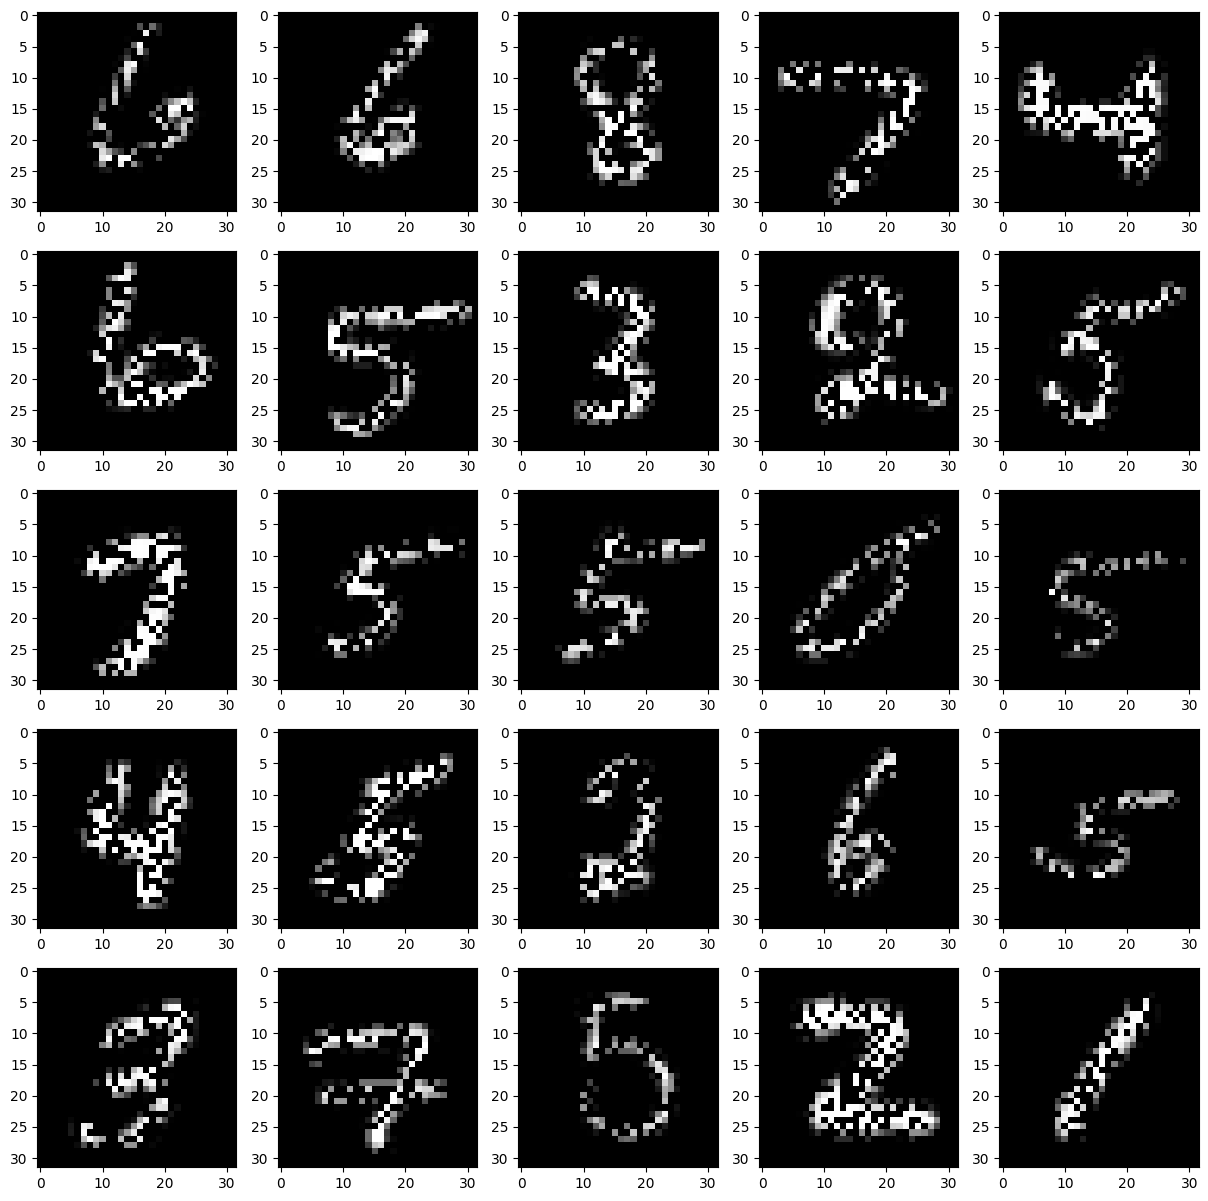

In [ ]:
#Let's visualize some examples

print("Normalized images")
ind = np.random.randint(0, 12000, 25)
fig, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (15,15))
for i in range(25):
    ax[i%5, i//5].imshow(imstack_norm[ind[i],0], cmap = 'gray')

print("Noisy images")
fig1, ax1 = plt.subplots(nrows = 5, ncols = 5, figsize = (15,15))
for i in range(25):
    ax1[i%5, i//5].imshow(imstack_noisy[ind[i],0], cmap = 'gray')

print("Missing Pixel images")
fig2, ax2 = plt.subplots(nrows = 5, ncols = 5, figsize = (15,15))
for i in range(25):
    ax2[i%5, i//5].imshow(imstack_mispx[ind[i],0], cmap = 'gray')


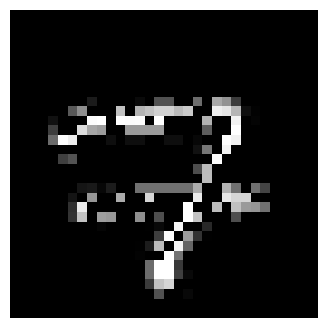

In [ ]:
# for i in range(10):
plt.figure(figsize = (4,4))
plt.imshow(imstack_mispx[ind[9],0], cmap = 'gray')
plt.axis('off')
plt.savefig('missing_px_eg.png', dpi = 300)

In [ ]:
# First let's train a regular autoencoder on the original dataset and see what
# the latent space looks like

torch.manual_seed(0)    # adding seed for reproducibility
input_dim = (1,32,32)

ae = AE(input_dim, latent_dim = 2)  # Latent dimensions are set to 2 for visualization purposes

t = Trainer(ae, X_train = imstack_norm, y_train = imstack_norm, batch_size = 120)
t.fit(100)

Epoch: 1... Training loss: 0.0938...
Epoch: 2... Training loss: 0.0493...
Epoch: 3... Training loss: 0.0445...
Epoch: 4... Training loss: 0.0411...
Epoch: 5... Training loss: 0.0388...
Epoch: 6... Training loss: 0.0373...
Epoch: 7... Training loss: 0.0364...
Epoch: 8... Training loss: 0.0363...
Epoch: 9... Training loss: 0.0358...
Epoch: 10... Training loss: 0.0354...
Epoch: 11... Training loss: 0.0349...
Epoch: 12... Training loss: 0.0349...
Epoch: 13... Training loss: 0.0356...
Epoch: 14... Training loss: 0.0350...
Epoch: 15... Training loss: 0.0336...
Epoch: 16... Training loss: 0.0333...
Epoch: 17... Training loss: 0.0332...
Epoch: 18... Training loss: 0.0328...
Epoch: 19... Training loss: 0.0327...
Epoch: 20... Training loss: 0.0320...
Epoch: 21... Training loss: 0.0322...
Epoch: 22... Training loss: 0.0321...
Epoch: 23... Training loss: 0.0318...
Epoch: 24... Training loss: 0.0317...
Epoch: 25... Training loss: 0.0317...
Epoch: 26... Training loss: 0.0316...
Epoch: 27... Training

Latent Distributions:
Input images are represented as points in the latent space using the encoder
These points are then colored with various ground-truth properties to visualize their distribution

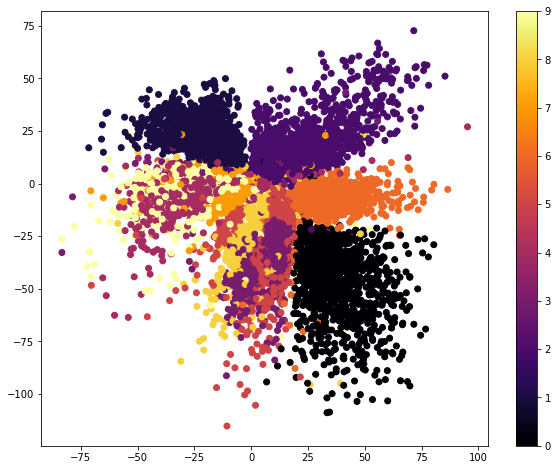

In [ ]:
# Visualizing the latent space distribution of the regular autoencoder
z = ae.encode(imstack_norm)
plt.figure(figsize = (10,8))
plt.scatter(z[:,0], z[:,1], c = labels_train, cmap = 'inferno')
plt.colorbar()

# plt.savefig('AE latent dist.png', dpi = 300)

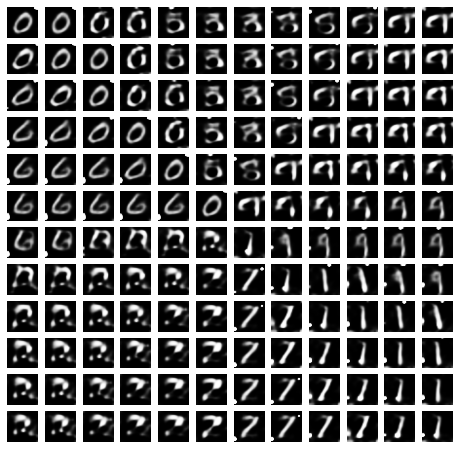

In [ ]:
# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions.
# These points are decoded back into the image space and are plotted in their corresponding latent space positions

grid = ae.decode_grid(12, [-100,100], [-100, 100])
fig, ax = plt.subplots(nrows = 12, ncols = 12, figsize = (8,8))
for i in range(144):
    ax[i%12, i//12].imshow(grid[i], cmap = 'gray')
    ax[i%12, i//12].axis('off')

# plt.savefig('AE latent space.png', dpi = 300)

## Denoising autoencoder

In [ ]:
# Here we train a denoising autoencoder where the input is the noisy images
# and the output is the set of cleaned images. The AE tries to reconstruct
# the cleaned images when shown a set of noisy images.

dae = DAE(ndim = 2)
t = Trainer(dae, X_train = imstack_noisy,   # here the input is the noisy image set
            y_train = imstack_norm,   # And the output is the cleaned dataset
            batch_size = 120)
t.fit(100)

Epoch: 1... Training loss: 0.0499...
Epoch: 2... Training loss: 0.0187...
Epoch: 3... Training loss: 0.0150...
Epoch: 4... Training loss: 0.0134...
Epoch: 5... Training loss: 0.0123...
Epoch: 6... Training loss: 0.0116...
Epoch: 7... Training loss: 0.0111...
Epoch: 8... Training loss: 0.0106...
Epoch: 9... Training loss: 0.0103...
Epoch: 10... Training loss: 0.0099...
Epoch: 11... Training loss: 0.0097...
Epoch: 12... Training loss: 0.0094...
Epoch: 13... Training loss: 0.0092...
Epoch: 14... Training loss: 0.0090...
Epoch: 15... Training loss: 0.0089...
Epoch: 16... Training loss: 0.0087...
Epoch: 17... Training loss: 0.0084...
Epoch: 18... Training loss: 0.0084...
Epoch: 19... Training loss: 0.0082...
Epoch: 20... Training loss: 0.0080...
Epoch: 21... Training loss: 0.0079...
Epoch: 22... Training loss: 0.0078...
Epoch: 23... Training loss: 0.0077...
Epoch: 24... Training loss: 0.0075...
Epoch: 25... Training loss: 0.0075...
Epoch: 26... Training loss: 0.0075...
Epoch: 27... Training

In [ ]:
# Here we make the prediction on the noisy images
# We can also use the remaining images from the MNIST dataset for validation purposes
cleaned_imgs = dae.predict(imstack_noisy)
random_inds = np.random.randint(0, 12000, 25)

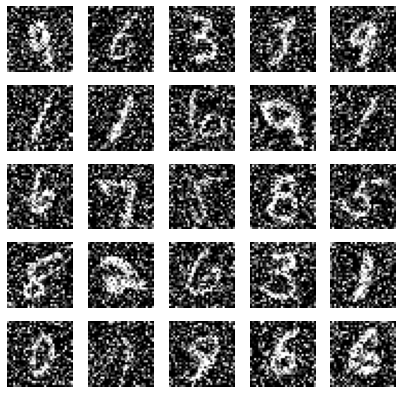

In [ ]:
# 25 randomly selected inputs to the denoising autoencoder

fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = (7,7))
for i in range(25):
    ax[i%5, i//5].imshow(imstack_noisy[random_inds[i], 0], cmap = 'gray')
    ax[i%5, i//5].axis('off')

plt.savefig('AE denoising inputs.png', dpi = 300)

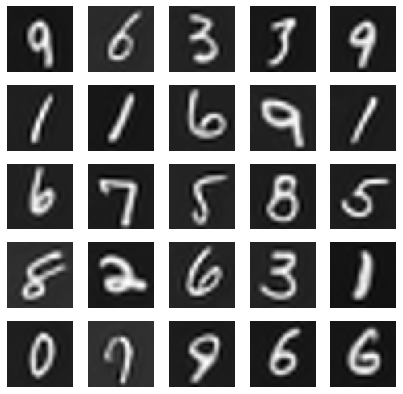

In [ ]:
# Outputs of the denoising autoencoder for the images that are shown above

fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = (7,7))
for i in range(25):
    ax[i%5, i//5].imshow(cleaned_imgs[random_inds[i], 0], cmap = 'gray')
    ax[i%5, i//5].axis('off')
plt.savefig('AE denoising outputs.png', dpi = 300)

## Filling missing pixels

In [ ]:
#Here we train an autoencoder whose inputs are images with 50% of the pixels missing
# The output to this autoencoder are the original images from the dataset i.e.,
# clean and all the pixels filled

mp_dae = DAE(ndim = 2)

t = Trainer(mp_dae, X_train = imstack_mispx,   # here the input is the missing pixels dataset
            y_train = imstack_norm,   # And the output is the filled-dataset
            batch_size = 120)
t.fit(100)

Epoch: 1... Training loss: 0.0461...
Epoch: 2... Training loss: 0.0150...
Epoch: 3... Training loss: 0.0116...
Epoch: 4... Training loss: 0.0102...
Epoch: 5... Training loss: 0.0092...
Epoch: 6... Training loss: 0.0086...
Epoch: 7... Training loss: 0.0081...
Epoch: 8... Training loss: 0.0077...
Epoch: 9... Training loss: 0.0074...
Epoch: 10... Training loss: 0.0072...
Epoch: 11... Training loss: 0.0069...
Epoch: 12... Training loss: 0.0067...
Epoch: 13... Training loss: 0.0066...
Epoch: 14... Training loss: 0.0065...
Epoch: 15... Training loss: 0.0064...
Epoch: 16... Training loss: 0.0062...
Epoch: 17... Training loss: 0.0062...
Epoch: 18... Training loss: 0.0061...
Epoch: 19... Training loss: 0.0060...
Epoch: 20... Training loss: 0.0059...
Epoch: 21... Training loss: 0.0059...
Epoch: 22... Training loss: 0.0058...
Epoch: 23... Training loss: 0.0057...
Epoch: 24... Training loss: 0.0056...
Epoch: 25... Training loss: 0.0056...
Epoch: 26... Training loss: 0.0057...
Epoch: 27... Training

In [ ]:
# Making predictions on the input dataset using the trained autoencoder
filled_imgs = mp_dae.predict(imstack_mispx)
random_inds = np.random.randint(0, 12000, 25)

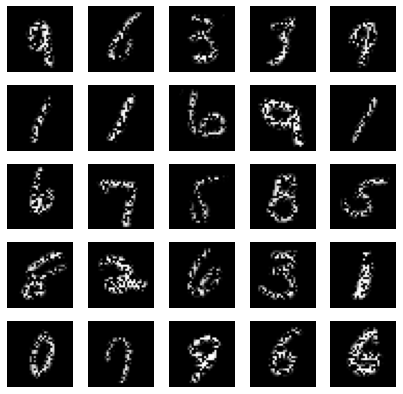

In [ ]:
# 25 randomly selected inputs to the missing-pixel autoencoder

fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = (7,7))
for i in range(25):
    ax[i%5, i//5].imshow(imstack_mispx[random_inds[i], 0], cmap = 'gray')
    ax[i%5, i//5].axis('off')
plt.savefig('AE mispix inputs.png', dpi = 300)

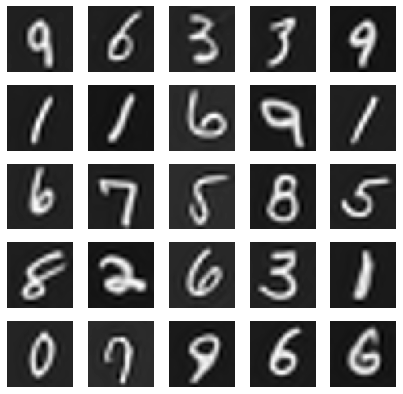

In [ ]:
# Predicted outputs of the missing pixel autoencoder for the inputs that are shown above

fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = (7,7))
for i in range(25):
    ax[i%5, i//5].imshow(filled_imgs[random_inds[i], 0], cmap = 'gray')
    ax[i%5, i//5].axis('off')
plt.savefig('AE mispix outputs.png', dpi = 300)

# Variational Autoencoders

In [ ]:
# Download the MNIST dataset here
from torchvision import datasets
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [ ]:
imstack_train_o = mnist_trainset.train_data.numpy()
labels_train = mnist_trainset.train_labels.numpy()

/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
# Rotating each image by a randomly sampled angle from [-90, 90] degrees

np.random.seed(0)

imstack_rot_train = np.zeros_like(imstack_train_o)

for i, digit in enumerate(imstack_train_o):
    im = Image.fromarray(digit)
    im = im.rotate(np.random.randint(-90, 90), resample=Image.BICUBIC)
    imstack_rot_train[i] = im

imstack_rot_train = imstack_rot_train / imstack_rot_train.max()
imstack_norm_train = imstack_train_o / imstack_train_o.max()

print(imstack_rot_train.shape)

(60000, 28, 28)


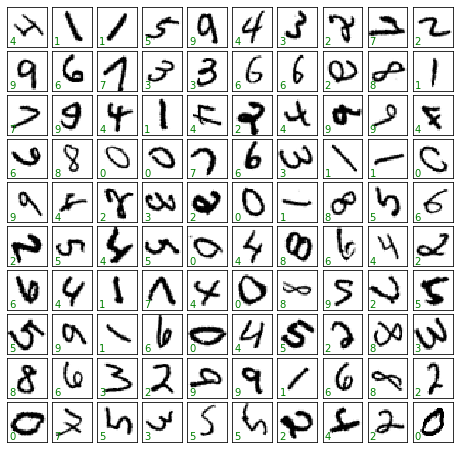

In [ ]:
# Visualizing the rotated dataset
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(imstack_rot_train))
    ax.imshow(imstack_rot_train[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(labels_train[i]),
            transform=ax.transAxes, color='green')

# plt.savefig('rotated_mnist.png', dpi = 300)

## VAE on the not-rotated MNIST dataset

In [ ]:
# First we train a VAE on the unrotated dataset

input_dim = (28, 28)

# Intitialize model
vae_o = aoi.models.VAE(input_dim)
# Train
vae_o.fit(imstack_norm_train, training_cycles=100, batch_size=100, seed = 0)

Epoch: 1/100, Training loss: 28.0596
Epoch: 2/100, Training loss: 24.4570
Epoch: 3/100, Training loss: 24.0215
Epoch: 4/100, Training loss: 23.7429
Epoch: 5/100, Training loss: 23.4808
Epoch: 6/100, Training loss: 23.2527
Epoch: 7/100, Training loss: 23.0646
Epoch: 8/100, Training loss: 22.9196
Epoch: 9/100, Training loss: 22.7865
Epoch: 10/100, Training loss: 22.6650
Epoch: 11/100, Training loss: 22.5757
Epoch: 12/100, Training loss: 22.4776
Epoch: 13/100, Training loss: 22.4048
Epoch: 14/100, Training loss: 22.3423
Epoch: 15/100, Training loss: 22.2951
Epoch: 16/100, Training loss: 22.2291
Epoch: 17/100, Training loss: 22.1812
Epoch: 18/100, Training loss: 22.1436
Epoch: 19/100, Training loss: 22.0892
Epoch: 20/100, Training loss: 22.0282
Epoch: 21/100, Training loss: 21.9902
Epoch: 22/100, Training loss: 21.9431
Epoch: 23/100, Training loss: 21.9004
Epoch: 24/100, Training loss: 21.8574
Epoch: 25/100, Training loss: 21.8110
Epoch: 26/100, Training loss: 21.7758
Epoch: 27/100, Traini

Latent Distributions:
Input images are represented as points in the latent space using the encoder
These points are then colored with various ground-truth properties to visualize their distribution

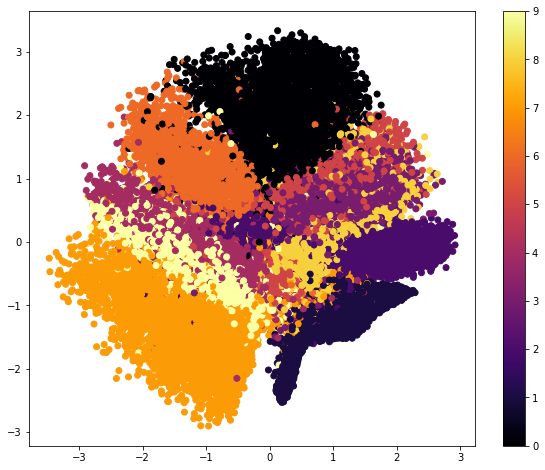

In [ ]:
# Plotting the latent distributions of the unrotated dataset

zvae_o = vae_o.encode(imstack_norm_train)
mean_o, sd_o = zvae_o[0], zvae_o[1]
plt.figure(figsize = (10,8))
plt.scatter(mean_o[:,0], mean_o[:,1], c = labels_train, cmap = 'inferno')
plt.colorbar()

# plt.savefig('vae_mnist_latentdis.png', dpi = 300)

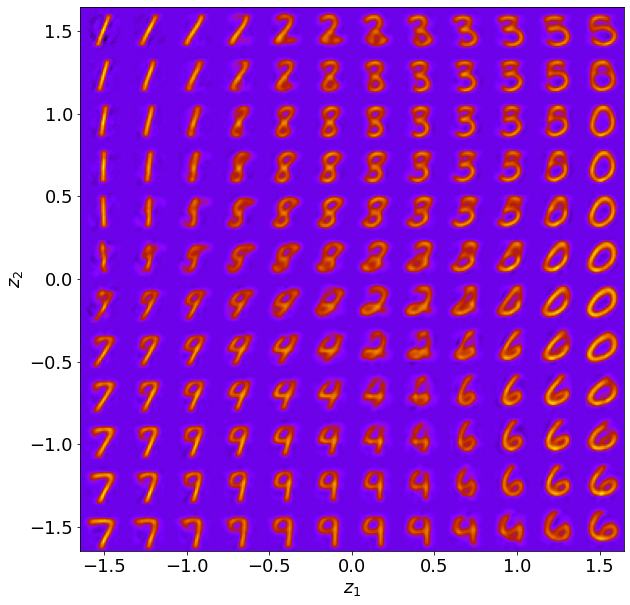

array([[0.18563824, 0.18728061, 0.18409491, ..., 0.18595694, 0.18473521,
        0.1865029 ],
       [0.18682665, 0.1854561 , 0.18455087, ..., 0.18580043, 0.18446256,
        0.18397376],
       [0.18403475, 0.18947885, 0.18512416, ..., 0.18187124, 0.18359485,
        0.18647121],
       ...,
       [0.18567042, 0.18475935, 0.18499196, ..., 0.1854804 , 0.18539968,
        0.18540479],
       [0.18543376, 0.18413017, 0.18466028, ..., 0.18278135, 0.18607732,
        0.18741922],
       [0.1854807 , 0.18525554, 0.18455244, ..., 0.18496092, 0.18577016,
        0.18513021]])

In [ ]:
# Decoded latent space of the unrotated dataset:
# The latent space is uniformly sampled in z1-z2 latent dimensions.
# These points are decoded back into the image space and are plotted in their corresponding latent space positions
vae_o.manifold2d(d=12, origin='upper')

## VAE on the rotated MNIST dataset

In [ ]:
# Training the VAE on the rotated dataset
input_dim = (28, 28)

# Intitialize model
vae = aoi.models.VAE(input_dim)
# Train
vae.fit(imstack_rot_train, training_cycles=100, batch_size=100, seed = 0)

Epoch: 1/100, Training loss: 28.7364
Epoch: 2/100, Training loss: 26.1958
Epoch: 3/100, Training loss: 26.0264
Epoch: 4/100, Training loss: 25.3259
Epoch: 5/100, Training loss: 25.1340
Epoch: 6/100, Training loss: 25.0102
Epoch: 7/100, Training loss: 24.9075
Epoch: 8/100, Training loss: 24.8272
Epoch: 9/100, Training loss: 24.7513
Epoch: 10/100, Training loss: 24.6772
Epoch: 11/100, Training loss: 24.6297
Epoch: 12/100, Training loss: 24.5662
Epoch: 13/100, Training loss: 24.5216
Epoch: 14/100, Training loss: 24.4771
Epoch: 15/100, Training loss: 24.4479
Epoch: 16/100, Training loss: 24.3924
Epoch: 17/100, Training loss: 24.3597
Epoch: 18/100, Training loss: 24.3317
Epoch: 19/100, Training loss: 24.2891
Epoch: 20/100, Training loss: 24.2333
Epoch: 21/100, Training loss: 24.2071
Epoch: 22/100, Training loss: 24.1844
Epoch: 23/100, Training loss: 24.1599
Epoch: 24/100, Training loss: 24.1363
Epoch: 25/100, Training loss: 24.1154
Epoch: 26/100, Training loss: 24.1021
Epoch: 27/100, Traini

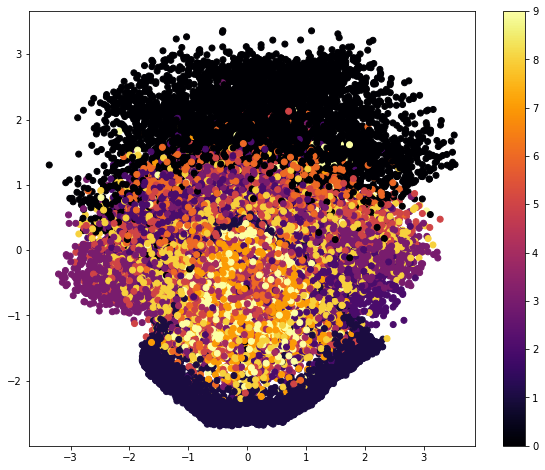

In [ ]:
# Latent distributions of the VAE trained on the rotated MNIST dataset

zvae = vae.encode(imstack_rot_train)
mean, sd = zvae[0], zvae[1]
plt.figure(figsize = (10,8))
plt.scatter(mean[:,0], mean[:,1], c = labels_train, cmap = 'inferno')
plt.colorbar()

# plt.savefig('vae_rotmnist_latentdis.png', dpi = 300)

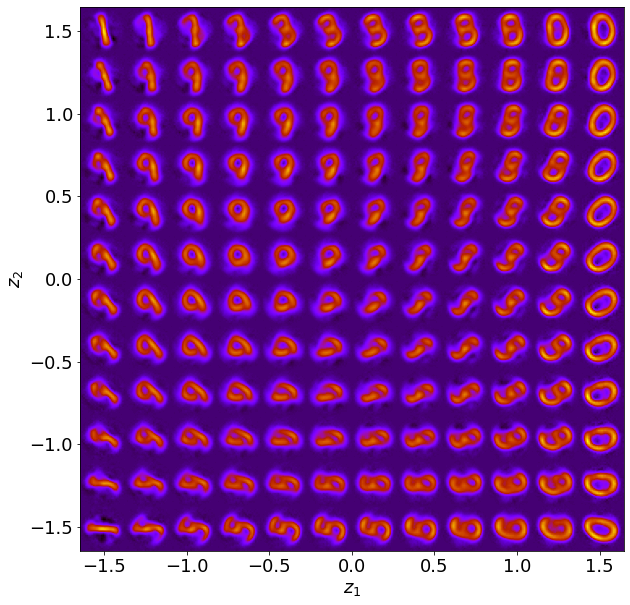

array([[0.0764567 , 0.07448256, 0.07485708, ..., 0.07446078, 0.07643653,
        0.07639586],
       [0.07498985, 0.07701934, 0.07606063, ..., 0.07423077, 0.07351977,
        0.07525662],
       [0.07545458, 0.07623074, 0.07509669, ..., 0.0722394 , 0.07428044,
        0.0773793 ],
       ...,
       [0.07488972, 0.07432161, 0.0759279 , ..., 0.07753751, 0.0761896 ,
        0.07541431],
       [0.07573812, 0.0765256 , 0.07486973, ..., 0.07502856, 0.07613456,
        0.07541145],
       [0.07768399, 0.07754186, 0.07399184, ..., 0.07876236, 0.07331961,
        0.07705498]])

In [ ]:
# Latent space of the VAE trained on the rotated MNIST dataset
vae.manifold2d(d=12, origin='upper')

## rVAE on the rotated MNIST dataset

In [ ]:
# Training the rVAE on the rotated MNIST dataset
input_dim = (28, 28)

# Intitialize model
rvae = aoi.models.rVAE(input_dim)
# Train
rvae.fit(imstack_rot_train, rotation_prior=np.pi/4, training_cycles=100, batch_size=100, seed = 0)

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 1/100, Training loss: 31.1839
Epoch: 2/100, Training loss: 28.5577
Epoch: 3/100, Training loss: 27.9800
Epoch: 4/100, Training loss: 27.6585
Epoch: 5/100, Training loss: 27.3727
Epoch: 6/100, Training loss: 27.1926
Epoch: 7/100, Training loss: 27.0148
Epoch: 8/100, Training loss: 26.8526
Epoch: 9/100, Training loss: 26.6873
Epoch: 10/100, Training loss: 26.5099
Epoch: 11/100, Training loss: 26.3151
Epoch: 12/100, Training loss: 26.1063
Epoch: 13/100, Training loss: 25.9147
Epoch: 14/100, Training loss: 25.7064
Epoch: 15/100, Training loss: 25.5249
Epoch: 16/100, Training loss: 25.3540
Epoch: 17/100, Training loss: 25.2375
Epoch: 18/100, Training loss: 25.1209
Epoch: 19/100, Training loss: 25.0294
Epoch: 20/100, Training loss: 24.9229
Epoch: 21/100, Training loss: 24.8501
Epoch: 22/100, Training loss: 24.7674
Epoch: 23/100, Training loss: 24.6835
Epoch: 24/100, Training loss: 24.6118
Epoch: 25/100, Training loss: 24.5490
Epoch: 26/100, Training loss: 24.4895
Epoch: 27/100, Traini

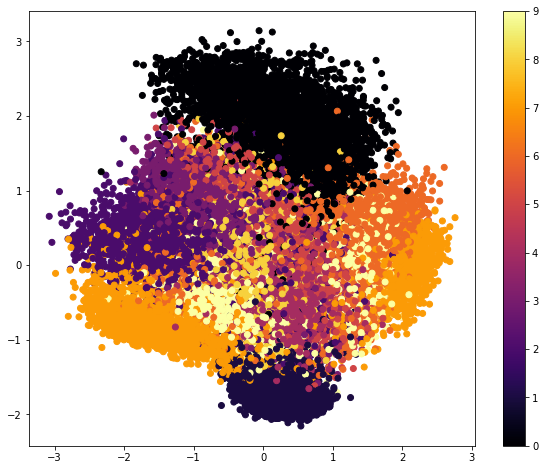

In [ ]:
# Latent distributions of the rVAE trained on the rotated MNIST dataset

z_mean, z_sd = rvae.encode(imstack_rot_train)
# The first latent variable is the angle, then the next two are the translations in x and y directions
# Then the rest of the latent variables are the number of user-selected latent dimensions
z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]
plt.figure(figsize = (10,8))
plt.scatter(z3[:,0], z3[:,1], c = labels_train, cmap = 'inferno')
plt.colorbar()

# plt.savefig('rvae_mnist_latentdis.png', dpi = 300)

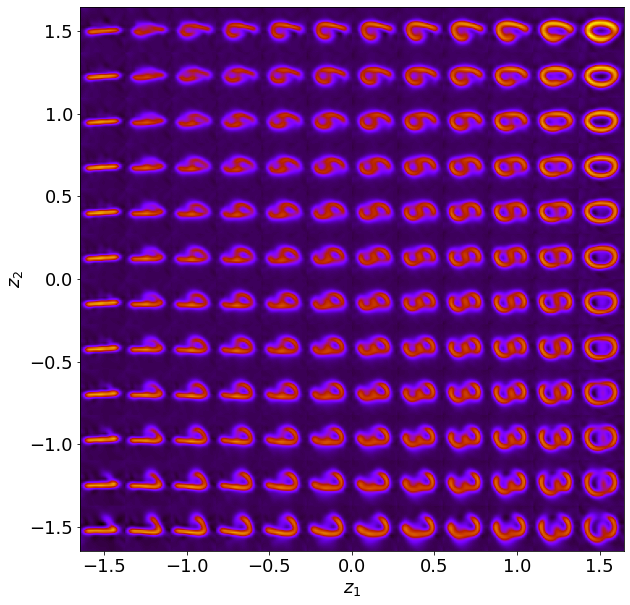

array([[0.07160462, 0.07880849, 0.0804752 , ..., 0.06737285, 0.06868908,
        0.07080022],
       [0.06439118, 0.07236655, 0.07640301, ..., 0.06941198, 0.07128187,
        0.07383422],
       [0.05932916, 0.06601074, 0.07062488, ..., 0.07040381, 0.07284044,
        0.07570781],
       ...,
       [0.07075051, 0.06874893, 0.06443143, ..., 0.05568363, 0.0554417 ,
        0.05288328],
       [0.06679564, 0.06680824, 0.06433891, ..., 0.06015936, 0.06132626,
        0.0589316 ],
       [0.06605029, 0.06692784, 0.06511947, ..., 0.06327734, 0.0658435 ,
        0.06554342]])

In [ ]:
# Decoded latent space of the rVAE trained on the rotated MNIST dataset
rvae.manifold2d(d=12, origin='upper')

# VAE on Cards

In [ ]:
#@title Helper function
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    !gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
    !unzip -o -qq cards.zip
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


def transform_images(*args, **kwargs):
    card1, card2, card3, card4 = args
    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = kwargs.get("shear")
    z = kwargs.get("scale")
    n_samples = kwargs.get("samples", 3000)
    torch.manual_seed(kwargs.get("seed", 0))
    # Define transform(s)
    transform = nn.Sequential(
        K.augmentation.CenterCrop((48, 48)),
        K.augmentation.RandomAffine(a, translate=t, shear=[-s, s, -s, s], scale=z, p=1),
    )
    # Apply random transformations to a batch of 3000 images for each card type
    cards1 = transform(card1[None, None].repeat_interleave(n_samples, dim=0))
    cards2 = transform(card2[None, None].repeat_interleave(n_samples, dim=0))
    cards3 = transform(card3[None, None].repeat_interleave(n_samples, dim=0))
    cards4 = transform(card4[None, None].repeat_interleave(n_samples, dim=0))

    # Concatenate (this is our training set)
    cards_all = torch.cat([cards1, cards2, cards3, cards4]).squeeze().float()
    labels_all = torch.cat([torch.zeros(n_samples), torch.ones(n_samples),
                           2*torch.ones(n_samples), 3*torch.ones(n_samples)])
    return cards_all.flatten(1)


def plot_manifolds(model):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

In [ ]:
cards = get_data()

labels_all = np.zeros(12000)
labels_all[0:3000] = 0
labels_all[3000:6000] = 1
labels_all[6000:9000] = 2
labels_all[9000:12000] = 3

Epoch: 1/200, Training loss: 714.1263
Epoch: 2/200, Training loss: 445.2249
Epoch: 3/200, Training loss: 429.1179
Epoch: 4/200, Training loss: 394.7362
Epoch: 5/200, Training loss: 359.9066
Epoch: 6/200, Training loss: 299.2272
Epoch: 7/200, Training loss: 254.6184
Epoch: 8/200, Training loss: 229.3417
Epoch: 9/200, Training loss: 211.7778
Epoch: 10/200, Training loss: 199.1127
Epoch: 11/200, Training loss: 189.7296
Epoch: 12/200, Training loss: 182.9272
Epoch: 13/200, Training loss: 177.5863
Epoch: 14/200, Training loss: 173.2376
Epoch: 15/200, Training loss: 169.6853
Epoch: 16/200, Training loss: 166.4190
Epoch: 17/200, Training loss: 163.1345
Epoch: 18/200, Training loss: 159.8088
Epoch: 19/200, Training loss: 156.4139
Epoch: 20/200, Training loss: 153.1358
Epoch: 21/200, Training loss: 149.8070
Epoch: 22/200, Training loss: 146.6674
Epoch: 23/200, Training loss: 143.5844
Epoch: 24/200, Training loss: 140.5524
Epoch: 25/200, Training loss: 137.5034
Epoch: 26/200, Training loss: 134.

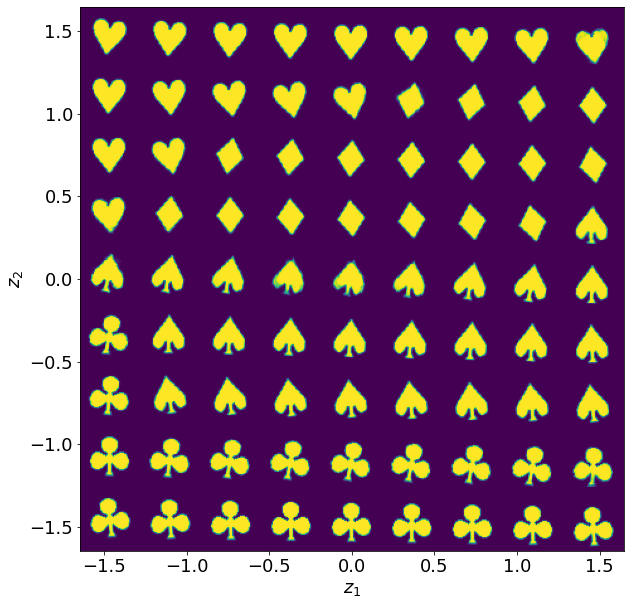

array([[1.36844447e-08, 8.12591061e-09, 4.68811168e-09, ...,
        7.93272381e-09, 4.12677004e-09, 3.41257045e-09],
       [4.80447948e-09, 7.43102646e-09, 6.09556272e-09, ...,
        2.85495538e-09, 7.16034743e-09, 3.96208044e-09],
       [7.65250796e-09, 6.18842533e-09, 1.52590562e-08, ...,
        4.90551377e-09, 3.11453818e-09, 3.19536220e-09],
       ...,
       [6.29830055e-09, 6.95508717e-09, 6.20189633e-09, ...,
        7.06251146e-09, 7.28326777e-09, 3.89795396e-09],
       [6.31665920e-09, 6.96505698e-09, 1.00008180e-08, ...,
        3.30108518e-09, 4.74159112e-09, 3.46607254e-09],
       [8.46625792e-09, 6.33150732e-09, 4.81915530e-09, ...,
        4.62867922e-09, 7.06451919e-09, 4.84279905e-09]])

In [ ]:
# The aug_parms correspond to different transformations applied on the raw data.
# The three parameters correspond to angle (in degrees), translations (in pixles), and shear (in degrees) applied on the data
aug_params = {1: [12, 0.1, 1], 2: [12, 0.1, 10], 3: [120, 0.1, 1], 4: [120, 0.1, 10]}

ind = 1
parms = aug_params[ind]

X_train1 = transform_images(
    *cards,
    shear=parms[2], scale=(1,1), angle=parms[0], translation=parms[1],
    samples=3000, seed=0)

X_train1 = X_train1.reshape([X_train1.shape[0], 48, 48])

input_dim = (48, 48)
latent_dim = 2
vae1 = aoi.models.VAE(input_dim, latent_dim=2,
                            numlayers_encoder=3, numhidden_encoder=512,
                            numlayers_decoder=3, numhidden_decoder=512,
                            skip=True)

vae1.fit(X_train1, training_cycles=200, batch_size=100, loss="ce")

vae1.manifold2d(cmap="viridis", origin="upper")

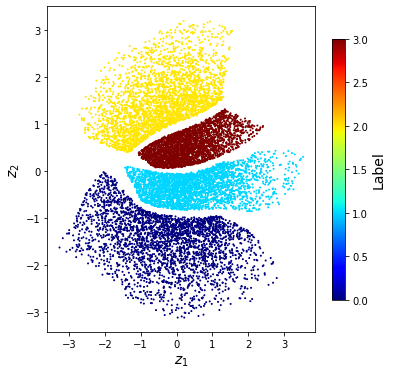

In [ ]:
z_mean1, z_sd1 = vae1.encode(X_train1)
fig, ax = plt.subplots(1, 1, figsize =(6, 6))
im = ax.scatter(z_mean1[:,-1], z_mean1[:,-2], c=labels_all, s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
# ax.set_xticks([])
# ax.set_yticks([])
# plt.savefig('latdis_lowrot_lowshear.png', dpi = 300)

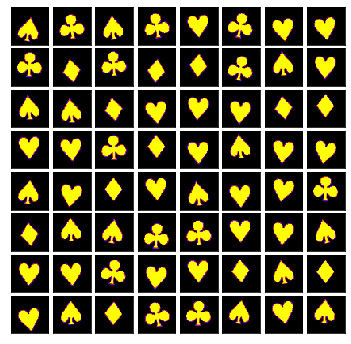

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(6, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_train1), size=(1,))
    im = X_train1[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')

# plt.savefig('lowrot_lowshear.png', dpi = 300)

Epoch: 1/200, Training loss: 722.6640
Epoch: 2/200, Training loss: 458.8720
Epoch: 3/200, Training loss: 450.3312
Epoch: 4/200, Training loss: 435.6654
Epoch: 5/200, Training loss: 403.4833
Epoch: 6/200, Training loss: 374.9517
Epoch: 7/200, Training loss: 343.1139
Epoch: 8/200, Training loss: 315.1984
Epoch: 9/200, Training loss: 289.1151
Epoch: 10/200, Training loss: 258.7827
Epoch: 11/200, Training loss: 242.1780
Epoch: 12/200, Training loss: 232.3667
Epoch: 13/200, Training loss: 225.7824
Epoch: 14/200, Training loss: 221.1475
Epoch: 15/200, Training loss: 217.5576
Epoch: 16/200, Training loss: 214.5856
Epoch: 17/200, Training loss: 212.3736
Epoch: 18/200, Training loss: 210.2924
Epoch: 19/200, Training loss: 208.3485
Epoch: 20/200, Training loss: 206.4278
Epoch: 21/200, Training loss: 204.3515
Epoch: 22/200, Training loss: 202.1267
Epoch: 23/200, Training loss: 199.5245
Epoch: 24/200, Training loss: 196.8003
Epoch: 25/200, Training loss: 193.8492
Epoch: 26/200, Training loss: 190.

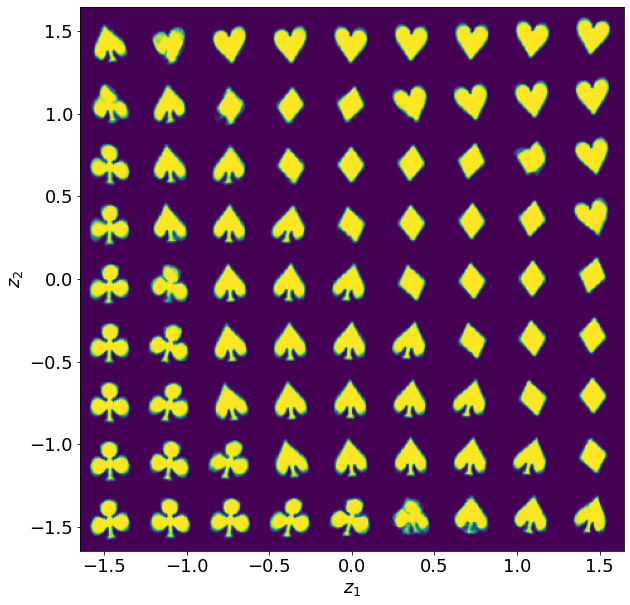

array([[3.04212877e-09, 1.77166470e-09, 1.33976086e-09, ...,
        2.99928127e-09, 1.84823357e-09, 2.05653961e-09],
       [1.19088550e-09, 1.58443392e-09, 1.89196570e-09, ...,
        1.24896116e-09, 2.66868461e-09, 1.88809768e-09],
       [1.80031290e-09, 9.67293246e-10, 2.90729663e-09, ...,
        1.78551918e-09, 1.44456536e-09, 1.89785343e-09],
       ...,
       [3.55284624e-09, 3.21350879e-09, 1.93390881e-09, ...,
        2.37126052e-09, 3.63312647e-09, 3.09104942e-09],
       [3.05735171e-09, 2.78227485e-09, 3.25913718e-09, ...,
        2.21920482e-09, 3.69118447e-09, 1.76432680e-09],
       [2.52582621e-09, 2.88291746e-09, 2.12155005e-09, ...,
        2.72356804e-09, 3.14823545e-09, 3.51960106e-09]])

In [ ]:
ind = 2
parms = aug_params[ind]

X_train2 = transform_images(
    *cards,
    shear=parms[2], scale=(1,1), angle=parms[0], translation=parms[1],
    samples=3000, seed=0)

X_train2 = X_train2.reshape([X_train1.shape[0], 48, 48])

input_dim = (48, 48)
latent_dim = 2
vae2 = aoi.models.VAE(input_dim, latent_dim=2,
                            numlayers_encoder=3, numhidden_encoder=512,
                            numlayers_decoder=3, numhidden_decoder=512,
                            skip=True)

vae2.fit(X_train2, training_cycles=200, batch_size=100, loss="ce")

vae2.manifold2d(cmap="viridis", origin="upper")

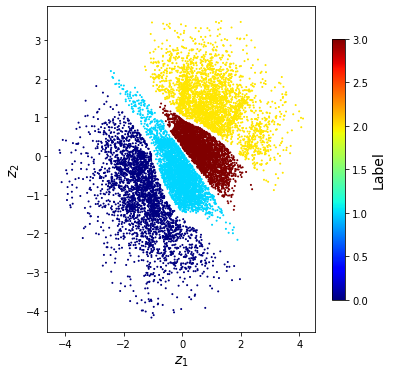

In [ ]:
z_mean2, z_sd2 = vae2.encode(X_train2)
fig, ax = plt.subplots(1, 1, figsize =(6, 6))
im = ax.scatter(z_mean2[:,-1], z_mean2[:,-2], c=labels_all, s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
# ax.set_xticks([])
# ax.set_yticks([])
# plt.savefig('latdis_lowrot_highshear.png', dpi = 300)


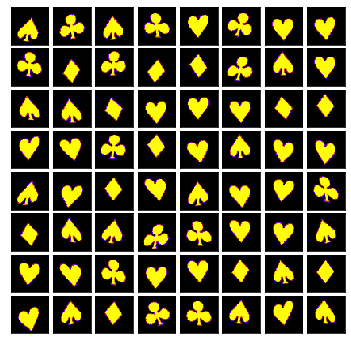

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(6, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_train2), size=(1,))
    im = X_train2[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')
# plt.savefig('lowrot_highshear.png', dpi = 300)

Epoch: 1/200, Training loss: 733.4000
Epoch: 2/200, Training loss: 472.6182
Epoch: 3/200, Training loss: 461.0303
Epoch: 4/200, Training loss: 451.4557
Epoch: 5/200, Training loss: 425.7255
Epoch: 6/200, Training loss: 382.9173
Epoch: 7/200, Training loss: 365.3599
Epoch: 8/200, Training loss: 355.7554
Epoch: 9/200, Training loss: 350.5038
Epoch: 10/200, Training loss: 346.6740
Epoch: 11/200, Training loss: 343.3806
Epoch: 12/200, Training loss: 339.7003
Epoch: 13/200, Training loss: 334.7782
Epoch: 14/200, Training loss: 327.8449
Epoch: 15/200, Training loss: 321.1246
Epoch: 16/200, Training loss: 314.8878
Epoch: 17/200, Training loss: 309.4114
Epoch: 18/200, Training loss: 304.7986
Epoch: 19/200, Training loss: 300.9346
Epoch: 20/200, Training loss: 296.6766
Epoch: 21/200, Training loss: 292.9071
Epoch: 22/200, Training loss: 289.2115
Epoch: 23/200, Training loss: 285.8670
Epoch: 24/200, Training loss: 282.6967
Epoch: 25/200, Training loss: 280.1661
Epoch: 26/200, Training loss: 277.

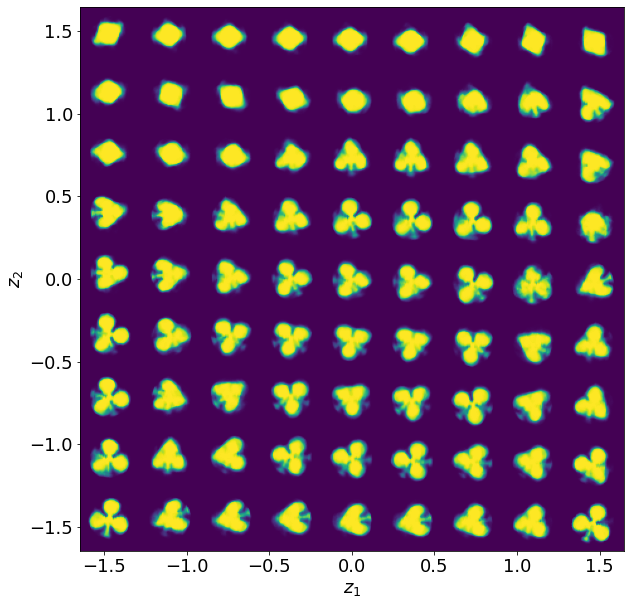

array([[1.27842514e-10, 6.27633640e-11, 3.03556451e-11, ...,
        3.68424069e-10, 1.98577849e-10, 2.47740578e-10],
       [2.10190840e-11, 8.14349629e-11, 9.33083263e-11, ...,
        8.97316804e-11, 2.74468170e-10, 1.39039585e-10],
       [4.21628114e-11, 4.03227625e-11, 1.92816221e-10, ...,
        2.26810695e-10, 1.04597074e-10, 1.57397817e-10],
       ...,
       [8.69588623e-10, 1.53317192e-09, 5.09796760e-10, ...,
        3.68204400e-09, 3.36574391e-09, 1.78271520e-09],
       [7.64350361e-10, 1.33265299e-09, 7.57579499e-10, ...,
        1.38041356e-09, 1.68641856e-09, 1.37070599e-09],
       [1.14299381e-09, 1.49018486e-09, 7.46716911e-10, ...,
        1.48381474e-09, 2.23668262e-09, 2.91275826e-09]])

In [ ]:
ind = 3
parms = aug_params[ind]

X_train3 = transform_images(
    *cards,
    shear=parms[2], scale=(1,1), angle=parms[0], translation=parms[1],
    samples=3000, seed=0)

X_train3 = X_train3.reshape([X_train3.shape[0], 48, 48])

input_dim = (48, 48)
latent_dim = 2
vae3 = aoi.models.VAE(input_dim, latent_dim=2,
                            numlayers_encoder=3, numhidden_encoder=512,
                            numlayers_decoder=3, numhidden_decoder=512,
                            skip=True)

vae3.fit(X_train3, training_cycles=200, batch_size=100, loss="ce")

vae3.manifold2d(cmap="viridis", origin="upper")

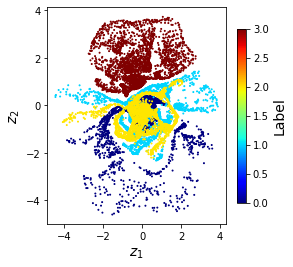

In [ ]:
z_mean3, z_sd3 = vae3.encode(X_train3)
fig, ax = plt.subplots(1, 1, figsize =(4, 4))
im = ax.scatter(z_mean3[:,-1], z_mean3[:,-2], c=labels_all, s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
# ax.set_xticks([])
# ax.set_yticks([])
# plt.savefig('latdis_highrot_lowshear.png', dpi = 300)

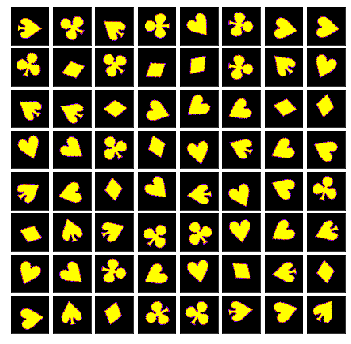

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(6, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_train3), size=(1,))
    im = X_train3[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')

# plt.savefig('highrot_lowshear.png', dpi = 300)

Epoch: 1/200, Training loss: 739.5833
Epoch: 2/200, Training loss: 482.1568
Epoch: 3/200, Training loss: 472.7721
Epoch: 4/200, Training loss: 462.9604
Epoch: 5/200, Training loss: 445.9644
Epoch: 6/200, Training loss: 399.8021
Epoch: 7/200, Training loss: 379.4457
Epoch: 8/200, Training loss: 369.6914
Epoch: 9/200, Training loss: 364.5293
Epoch: 10/200, Training loss: 360.9147
Epoch: 11/200, Training loss: 357.8164
Epoch: 12/200, Training loss: 354.3225
Epoch: 13/200, Training loss: 349.3615
Epoch: 14/200, Training loss: 343.0772
Epoch: 15/200, Training loss: 337.7332
Epoch: 16/200, Training loss: 333.1376
Epoch: 17/200, Training loss: 329.2922
Epoch: 18/200, Training loss: 325.9970
Epoch: 19/200, Training loss: 322.9297
Epoch: 20/200, Training loss: 320.0986
Epoch: 21/200, Training loss: 317.6020
Epoch: 22/200, Training loss: 315.0142
Epoch: 23/200, Training loss: 312.5010
Epoch: 24/200, Training loss: 310.4578
Epoch: 25/200, Training loss: 307.4039
Epoch: 26/200, Training loss: 305.

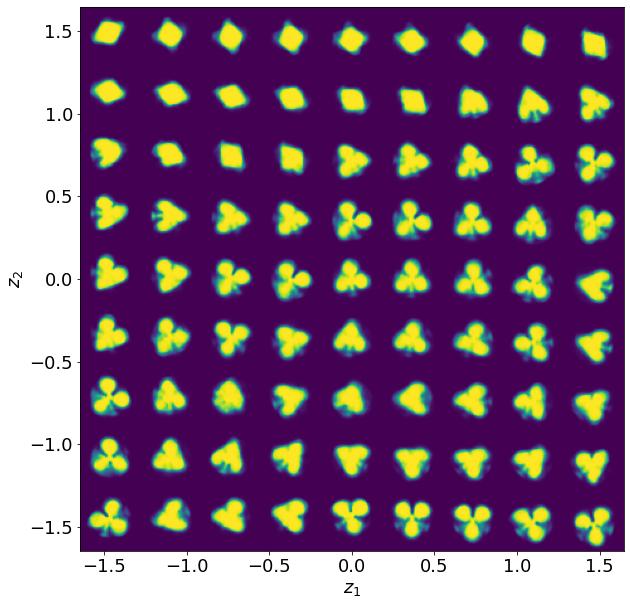

array([[4.23670321e-10, 2.65706762e-10, 1.17439364e-10, ...,
        1.18131360e-09, 4.05534023e-10, 4.78839413e-10],
       [1.34804459e-10, 2.76082185e-10, 1.00743816e-10, ...,
        2.19684493e-10, 6.08578965e-10, 3.14083898e-10],
       [2.10494663e-10, 1.44914566e-10, 4.24055124e-10, ...,
        4.68195260e-10, 3.29696825e-10, 3.21966037e-10],
       ...,
       [3.00945846e-09, 3.02024028e-09, 1.60785718e-09, ...,
        4.23655155e-09, 3.40219808e-09, 1.63399683e-09],
       [1.63455460e-09, 1.84893523e-09, 1.98778793e-09, ...,
        9.93213178e-10, 1.24837052e-09, 1.21009602e-09],
       [2.16930252e-09, 2.32218711e-09, 1.59050484e-09, ...,
        9.37895872e-10, 2.16755702e-09, 1.30105715e-09]])

In [ ]:
ind = 4
parms = aug_params[ind]

X_train4 = transform_images(
    *cards,
    shear=parms[2], scale=(1,1), angle=parms[0], translation=parms[1],
    samples=3000, seed=0)

X_train4 = X_train4.reshape([X_train4.shape[0], 48, 48])

input_dim = (48, 48)
latent_dim = 2
vae4 = aoi.models.VAE(input_dim, latent_dim=2,
                            numlayers_encoder=3, numhidden_encoder=512,
                            numlayers_decoder=3, numhidden_decoder=512,
                            skip=True)

vae4.fit(X_train4, training_cycles=200, batch_size=100, loss="ce")

vae4.manifold2d(cmap="viridis", origin="upper")

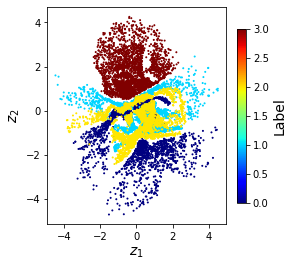

In [ ]:
z_mean4, z_sd4 = vae4.encode(X_train4)
fig, ax = plt.subplots(1, 1, figsize =(4, 4))
im = ax.scatter(z_mean4[:,-1], z_mean4[:,-2], c=labels_all, s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
# ax.set_xticks([])
# ax.set_yticks([])
# plt.savefig('latdis_highrot_highshear.png', dpi = 300)


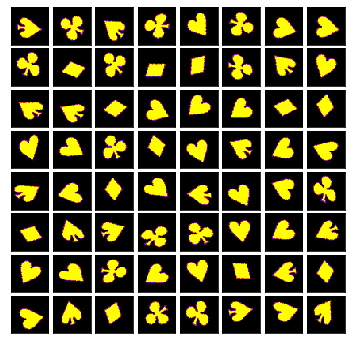

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(6, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = torch.randint(0, len(X_train4), size=(1,))
    im = X_train4[i]
    ax.imshow(im.view(48, 48), cmap='gnuplot', interpolation='nearest')

# plt.savefig('highrot_highshear.png', dpi = 300)